In [1]:
%pip install scikit-image
%pip install numpy opencv-python scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Memuat dan memproses citra dari database...
Berhasil memuat 2800 patch citra dari 112 kelas.
Melatih model CBIR...
Model berhasil dilatih menggunakan metric: canberra
Evaluasi performa sistem...
Hasil evaluasi (k=10):
  Rata-rata Precision: 0.0266
  Rata-rata Recall:    0.0266


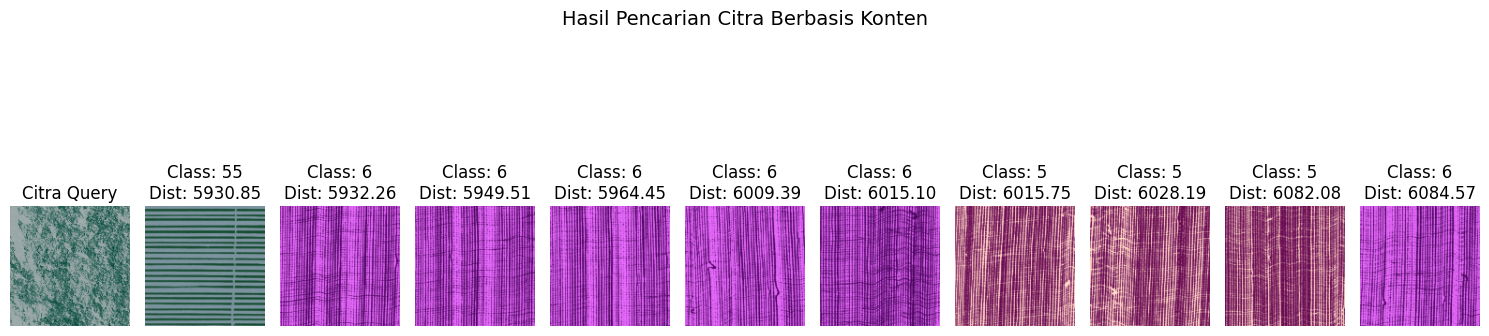

In [3]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class CBIRSystem:
    def __init__(self, database_path, patch_size=128, n_color_clusters=16):
        """
        Inisialisasi sistem CBIR
        
        Parameters:
            database_path (str): Path ke folder database Brodatz
            patch_size (int): Ukuran potongan citra (default: 128)
            n_color_clusters (int): Jumlah cluster untuk kuantisasi warna (default: 16)
        """
        self.database_path = database_path
        self.patch_size = patch_size
        self.n_color_clusters = n_color_clusters
        self.image_descriptors = []
        self.image_patches = []
        self.class_labels = []
        self.kmeans_color = None
        self.feature_scaler = None
        self.nn_model = None
        
    def load_and_preprocess_images(self):
        """Memuat dan memproses citra dari database"""
        print("Memuat dan memproses citra dari database...")
        
        # Daftar semua file citra dalam format D{nomor}_COLORED.tif
        image_files = sorted([f for f in os.listdir(self.database_path) 
                           if f.endswith('_COLORED.tif') and f.startswith('D')])
        
        for class_idx, img_file in enumerate(image_files):
            img_path = os.path.join(self.database_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Gagal memuat citra: {img_file}")
                continue
                
            # Split citra menjadi 25 patch (5x5 grid)
            rows, cols = img.shape[:2]
            if rows != 640 or cols != 640:
                img = cv2.resize(img, (640, 640))
                
            for i in range(5):
                for j in range(5):
                    y_start = i * self.patch_size
                    y_end = y_start + self.patch_size
                    x_start = j * self.patch_size
                    x_end = x_start + self.patch_size
                    
                    patch = img[y_start:y_end, x_start:x_end]
                    self.image_patches.append(patch)
                    self.class_labels.append(class_idx)
                    
                    # Ekstrak fitur dari patch
                    features = self.extract_features(patch)
                    self.image_descriptors.append(features)
                    
        self.image_descriptors = np.array(self.image_descriptors)
        self.class_labels = np.array(self.class_labels)
        print(f"Berhasil memuat {len(self.image_patches)} patch citra dari {len(image_files)} kelas.")
        
    def extract_features(self, image):
        """Mengekstrak fitur LBP dan warna dari citra"""
        # Konversi ke grayscale untuk LBP
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 1. Ekstrak fitur LBP (Local Binary Pattern)
        radius = 3
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Hitung Maximum Run Length dari LBP
        max_run_length = self.calculate_max_run_length(lbp)
        
        # 2. Ekstrak fitur warna menggunakan K-Means
        color_features = self.extract_color_features(image)
        
        # Gabungkan semua fitur
        features = np.concatenate([
            lbp.flatten(),          # Fitur tekstur (LBP)
            [max_run_length],       # Fitur run length
            color_features          # Fitur warna
        ])
        
        return features
        
    def calculate_max_run_length(self, lbp_image):
        """Menghitung maximum run length dari citra LBP"""
        max_run = 0
        rows, cols = lbp_image.shape
        
        # Periksa arah horizontal
        for i in range(rows):
            current_val = lbp_image[i, 0]
            current_run = 1
            
            for j in range(1, cols):
                if lbp_image[i, j] == current_val:
                    current_run += 1
                    max_run = max(max_run, current_run)
                else:
                    current_val = lbp_image[i, j]
                    current_run = 1
                    
        return max_run
        
    def extract_color_features(self, image):
        """Mengekstrak fitur warna menggunakan K-Means"""
        # Ubah bentuk citra menjadi array pixel
        pixels = image.reshape(-1, 3).astype(np.float32)
        
        # Latih model K-Means jika belum ada
        if self.kmeans_color is None:
            # Hitung ukuran sampel yang valid
            n_pixels = pixels.shape[0]  # Jumlah total piksel
            sample_size = min(10000, n_pixels)  # Ambil maksimal 10000 sampel
        
            # # Gunakan sampel pixel dari semua citra untuk training
            # sample_size = min(100000, len(pixels) * 10)
            # sample_pixels = pixels[np.random.choice(pixels.shape[0], sample_size, replace=False)]
            
            #Ambil sampel piksel untuk training
            sample_pixels = pixels[np.random.choice(n_pixels, sample_size, replace=False)]
            
            self.kmeans_color = KMeans(n_clusters=self.n_color_clusters, random_state=42)
            self.kmeans_color.fit(sample_pixels)
            
        # Prediksi cluster untuk semua pixel
        clusters = self.kmeans_color.predict(pixels)
        
        # Buat histogram warna
        hist, _ = np.histogram(clusters, bins=self.n_color_clusters, range=(0, self.n_color_clusters-1))
        hist = hist / hist.sum()  # Normalisasi
        
        return hist
        
    def train_model(self, distance_metric='canberra'):
        """Melatih model untuk pencarian citra"""
        print("Melatih model CBIR...")
        
        # Standarisasi fitur
        self.feature_scaler = StandardScaler()
        scaled_features = self.feature_scaler.fit_transform(self.image_descriptors)
        
        # Buat model Nearest Neighbors
        if distance_metric == 'canberra':
            self.nn_model = NearestNeighbors(n_neighbors=20, metric='canberra')
        elif distance_metric == 'euclidean':
            self.nn_model = NearestNeighbors(n_neighbors=20, metric='euclidean')
        else:  # manhattan
            self.nn_model = NearestNeighbors(n_neighbors=20, metric='manhattan')
            
        self.nn_model.fit(scaled_features)
        print(f"Model berhasil dilatih menggunakan metric: {distance_metric}")
        
    def query_image(self, query_image_path, k=10):
        """Mencari citra yang mirip dengan citra query"""
        query_img = cv2.imread(query_image_path)
        if query_img is None:
            print("Error: Gagal memuat citra query")
            return []
            
        # Resize citra query jika diperlukan
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
            
        # Ekstrak fitur
        query_features = self.extract_features(query_img)
        scaled_features = self.feature_scaler.transform([query_features])
        
        # Cari citra yang mirip
        distances, indices = self.nn_model.kneighbors(scaled_features, n_neighbors=k)
        
        # Kembalikan hasil
        results = []
        for i, dist in zip(indices[0], distances[0]):
            results.append({
                'patch': self.image_patches[i],
                'distance': dist,
                'class': self.class_labels[i]
            })
            
        return results
        
    def evaluate_retrieval(self, test_size=0.2, k=10):
        """Evaluasi performa sistem dengan precision dan recall"""
        print("Evaluasi performa sistem...")
        
        # Split data menjadi train dan test
        X_train, X_test, y_train, y_test = train_test_split(
            range(len(self.image_patches)), self.class_labels, 
            test_size=test_size, random_state=42
        )
        
        # Standarisasi fitur
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        
        # Buat model evaluasi
        eval_model = NearestNeighbors(n_neighbors=k, metric='canberra')
        eval_model.fit(scaled_features[X_train])
        
        precisions = []
        recalls = []
        
        for idx, true_label in zip(X_test, y_test):
            # Cari neighbors
            _, neighbor_indices = eval_model.kneighbors([scaled_features[idx]], n_neighbors=k)
            
            # Hitung precision dan recall
            neighbor_labels = y_train[neighbor_indices[0]]
            precision = np.sum(neighbor_labels == true_label) / k
            relevant = np.sum(y_train == true_label)
            retrieved_relevant = np.sum(neighbor_labels == true_label)
            recall = retrieved_relevant / min(relevant, k)
            
            precisions.append(precision)
            recalls.append(recall)
            
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        
        print(f"Hasil evaluasi (k={k}):")
        print(f"  Rata-rata Precision: {avg_precision:.4f}")
        print(f"  Rata-rata Recall:    {avg_recall:.4f}")
        
        return avg_precision, avg_recall
        
    def visualize_results(self, query_image_path, results):
        """Visualisasi hasil pencarian"""
        query_img = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
        
        plt.figure(figsize=(15, 5))
        plt.suptitle("Hasil Pencarian Citra Berbasis Konten", fontsize=14)
        
        # Tampilkan citra query
        plt.subplot(1, len(results)+1, 1)
        plt.imshow(query_img)
        plt.title("Citra Query")
        plt.axis('off')
        
        # Tampilkan hasil
        for i, result in enumerate(results[:10]):  # Tampilkan maksimal 10 hasil
            plt.subplot(1, len(results)+1, i+2)
            img = cv2.cvtColor(result['patch'], cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Class: {result['class']}\nDist: {result['distance']:.2f}")
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()

# Contoh penggunaan
if __name__ == "__main__":
    # Inisialisasi sistem
    database_path = "./Colored_Brodatz"  # Folder berisi citra D1_COLORED.tif sampai D112_COLORED.tif
    cbir = CBIRSystem(database_path)
    
    # Memuat dan memproses citra
    cbir.load_and_preprocess_images()
    
    # Melatih model dengan jarak Canberra
    cbir.train_model(distance_metric='canberra')
    
    # Evaluasi performa
    precision, recall = cbir.evaluate_retrieval(k=10)
    
    # Contoh pencarian
    query_path = "./Colored_Brodatz/D2_COLORED.tif"  # Citra query berukuran 128x128
    if os.path.exists(query_path):
        results = cbir.query_image(query_path, k=10)
        cbir.visualize_results(query_path, results)
    else:
        print(f"Citra query {query_path} tidak ditemukan")